Generate the 3:2:1 Crack spread and plot it

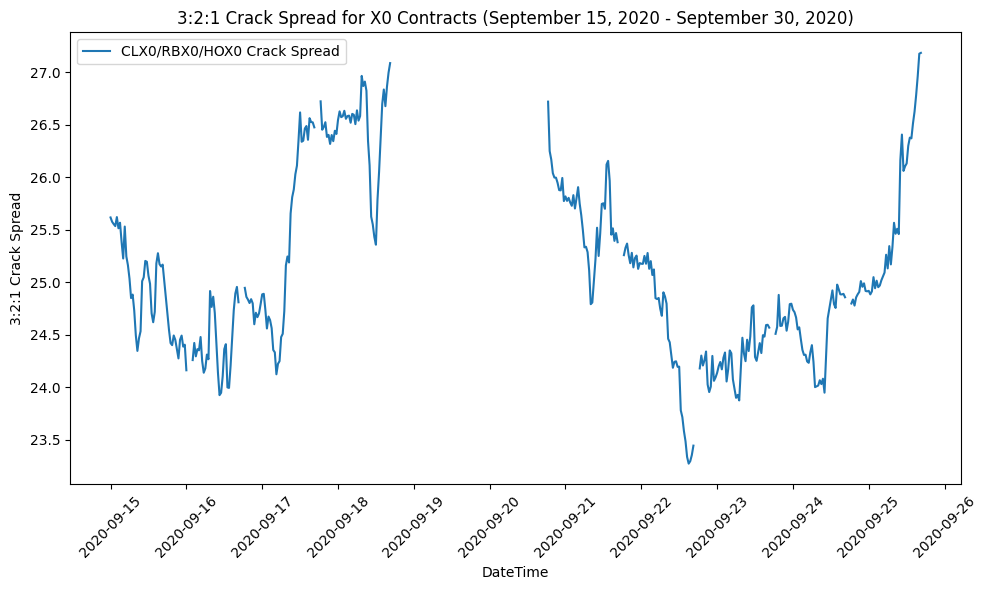

In [30]:
# This code generates the 3:2:1 crack spread, and plots it in a graph for hurricane harvey in August-September 2017. 

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Load data
file_path = 'bins20.csv'
data = pd.read_csv(file_path)

# Convert date and time to a datetime format
data['datetime'] = pd.to_datetime(data['date']) + pd.to_timedelta(data['time'], unit='min')

# Convert HO and RB prices to per barrel
data.loc[data['sym'].str.contains('HO') | data['sym'].str.contains('RB'), ['bid', 'ask', 'prc']] *= 42

# Filter data for the desired date range and specific contracts
start_date = datetime(2020, 9, 15)
end_date = datetime(2020, 9, 30)
filtered_data = data[(data['datetime'] >= start_date) & (data['datetime'] <= end_date)]
# filtered_data = filtered_data[filtered_data['sym'].isin(['CLU7', 'RBU7', 'HOU7', 'CLV7', 'RBV7', 'HOV7'])]
filtered_data = filtered_data[filtered_data['sym'].isin([ 'CLX0', 'RBX0', 'HOX0'])]


# Pivot the data for easier calculation
pivoted_data = filtered_data.pivot_table(index='datetime', columns='sym', values='prc')

# Calculate the 3:2:1 crack spreads
# pivoted_data['crack_spread_U7'] = -1 * (3 * pivoted_data['CLU7'] - 2 * pivoted_data['RBU7'] - pivoted_data['HOU7'])
pivoted_data['crack_spread_X0'] = -1* ( 3 * pivoted_data['CLX0'] - 2 * pivoted_data['RBX0'] - pivoted_data['HOX0'])

# Plotting
plt.figure(figsize=(10, 6))
# plt.plot(pivoted_data.index, pivoted_data['crack_spread_U7'], label='CLU7/RBU7/HOU7 Crack Spread')
plt.plot(pivoted_data.index, pivoted_data['crack_spread_X0'], label='CLX0/RBX0/HOX0 Crack Spread')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.xticks(rotation=45)
plt.xlabel('DateTime')
plt.ylabel('3:2:1 Crack Spread')
plt.title(f'3:2:1 Crack Spread for X0 Contracts ({start_date.strftime("%B %d, %Y")} - {end_date.strftime("%B %d, %Y")})')
plt.legend()
plt.tight_layout()
plt.show()



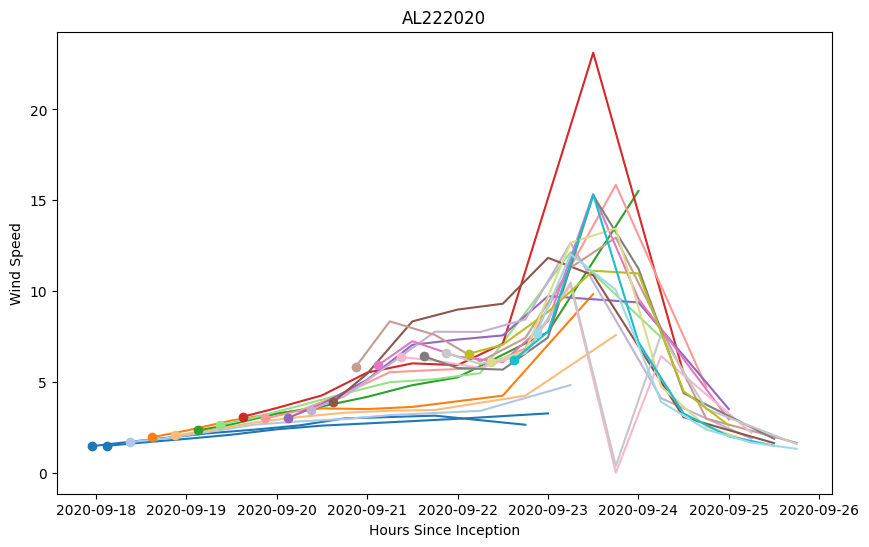

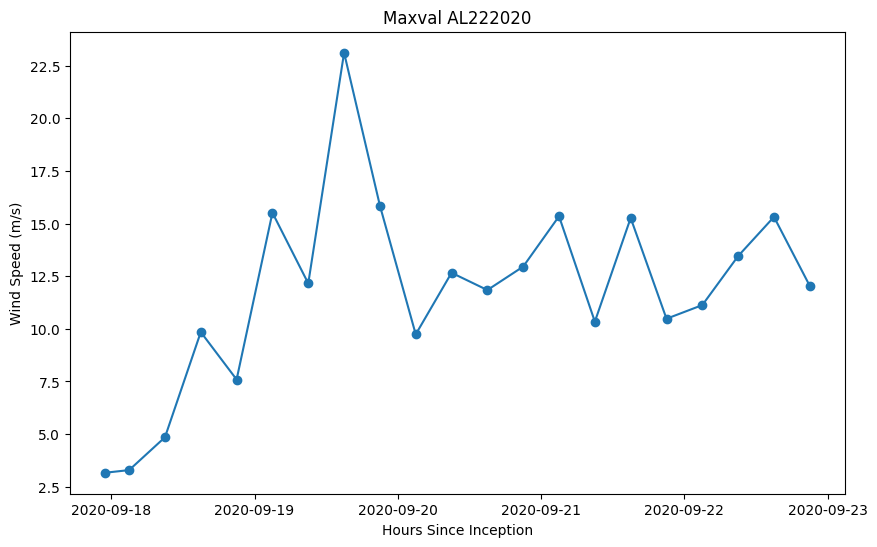

In [31]:
import matplotlib.pyplot as plt
import pickle
from dateutil import parser
import re
from matplotlib import cm
import numpy as np
from math import sin, cos, sqrt, atan2, radians
from datetime import datetime, timedelta
    
# function to define the hurricane score
def wind_speed(distance, v_m, r_m):

    b = 2
    x = 0
    s = 0.5
    x = ((r_m/distance)**b)*np.exp(1-(r_m/distance)**b)

    return v_m*x**s

# function to calculate distance using lat, lon (distance in km)
def distance(loc1, loc2):
    # Approximate radius of earth in km
    R = 6373.0

    lat1 = radians(loc1[0])
    lon1 = radians(loc1[1])
    lat2 = radians(loc2[0])
    lon2 = radians(loc2[1])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance

# define set of functions to predict Rmax8
def calc_f(lat):
    return 2*.00007292*sin(radians(lat))

def calc_mratio(v_max, r_175, lat):
    return 0.699 * np.exp(-0.00618*(v_max - 17.5)-0.00210*(v_max - 17.5)*(1/2*calc_f(lat)*r_175))

def calc_m175(r_175, lat):
    return r_175 * 17.5 + 1/2 * calc_f(lat)*r_175**2

def calc_rmax(v_max, r_175, lat):
    return v_max/(calc_f(lat))*(sqrt(1+2*calc_f(lat)*(calc_m175(r_175, lat)*calc_mratio(v_max, r_175, lat))/(v_max**2))-1)

# define list of storms to plot wind speed

storm_codes = ['AL222020']
month = 9

for storm in storm_codes:
    year = int(storm[-4:])

    with open(f"Data/{year}data.pkl", 'rb') as f:
        x = pickle.load(f)

    galveston = ([29.3013, -94.7977])

    # Initialize inception time (storm inception time)
    inception_time_str = x[storm]['1']['INIT']['Time (UTC)']
    inception_day = int(inception_time_str[:2])
    inception_month = month
    inception_year = year
    inception_hour = 0 # updated later
    inception_time = datetime(inception_year, inception_month, inception_day, inception_hour)

    # set up the figure for each storm
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.title(f"{storm}")
    plt.xlabel("Hours Since Inception")
    plt.ylabel("Wind Speed")

    day_count = 0
    prev28 = 0
    prev29 = 0
    prev30 = 0
    prev31 = 0
    base_day = list(inception_time_str)[0:2]
    base_day = [int(base_day[0]), int(base_day[1])]
    # print("BD1:", base_day)
    max_harr = []
    t_release = []

    for i, key in enumerate(x[storm].keys()):
        times = []
        wind_speeds = []
        lat_arr = []
        lon_arr = []
        hscore_arr = []
        peak_fspeed = 0 # to find the max speed in a given forecast

        for j, key2 in enumerate(x[storm][key].keys()):
        
            # print(key, key2) # for debugging

            if (x[storm][key][key2]['Dissipated?'] != True):

                lat = x[storm][key][key2]['Latitude']
                lon = x[storm][key][key2]['Longitude']
                ws_temp = x[storm][key][key2]['Wind Speed (KT)']   
                
                time_string = list(x[storm][key][key2]['Time (UTC)']) # need to include timing later

                current_day = [int(time_string[0]), int(time_string[1])]
                add31 = 0
                if ((current_day[0] - base_day[0])*10 + (current_day[1] - base_day[1])) < 0:
                    if prev_day == [3,1]:
                        prev31 = 1
                    elif prev_day == [3,0]:
                        prev30 = 1
                    elif prev_day == [2,9]:
                        prev29 = 1
                    elif prev_day == [2,8]:
                        prev28 = 1
                    
                    adds = prev28 * 28 + prev29 * 29 + prev30 * 30 + prev31 * 31
                    day_hrs = ((current_day[0] - base_day[0])*10 + (current_day[1] - base_day[1]) + adds)* 24
                    hour = int(time_string[3]) * 10 + int(time_string[4]) + day_hrs
                    # print(hour)
                    
                    current_datetime = inception_time + timedelta(hours=hour)
                    times.append(current_datetime)
                else:
                    day_hrs = ((current_day[0] - base_day[0])*10 + (current_day[1] - base_day[1]))* 24
                    hour = int(time_string[3]) * 10 + int(time_string[4]) + day_hrs
                    # print(hour)

                    # Extract time and convert to datetime
                    current_datetime = inception_time + timedelta(hours=hour)
                    times.append(current_datetime)
            
                wind_speeds.append(int(ws_temp))

                if (lat[-1] == "N"):
                    lat_arr.append(float(lat[0:-1]))
                elif (lat[-1] == "S"):
                    lat_arr.append(-float(lat[0:-1]))
                if (lon[-1] == "E"):
                    lon_arr.append(float(lon[0:-1]))
                elif (lon[-1] == "W"):
                    lon_arr.append(-float(lon[0:-1]))
                city = galveston
                dist = distance(city, np.array([lat_arr[-1], lon_arr[-1]]))
                windspeed_ms = int(ws_temp) * 0.5144 # change from knots to m/s
                hscore_arr.append(wind_speed(dist, windspeed_ms, calc_rmax(windspeed_ms, 60, lat_arr[-1]))) # calculate

                if (hscore_arr[-1] > peak_fspeed):
                    peak_fspeed = hscore_arr[-1]

                prev_day = current_day
        
        max_harr.append(peak_fspeed)
        t_release.append(times[0])

        colormap = cm.tab20
        color = colormap(i / len(x[storm]))

        # plotting the forecasts
        ax.plot(times[0], hscore_arr[0], marker = "o", color = color)
        ax.plot(times, hscore_arr, color=color, label = key)
        # ax.legend()

    plt.show()

    # max hscore plot per discussion
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    plt.title(f"Maxval {storm}")
    plt.xlabel("Hours Since Inception")
    plt.ylabel("Wind Speed (m/s)")
    ax2.plot(t_release, max_harr, marker = "o")
    plt.show()


    




In [41]:
import pandas as pd
from scipy.spatial import KDTree

# Your initial data: max_harr and t_release
# max_harr = [...]
# t_release = [...]

# Define the lag in minutes
lag_minutes = 0  # Adjust this as needed

# Step 1: Create DataFrame from max_harr and t_release, and filter
wind_speed_data = pd.DataFrame({
    'datetime': pd.Series(t_release),
    'max_harr': max_harr
}).query('max_harr >= 0')

# Step 2: Calculate t + lag for each datetime in wind speed data
wind_speed_data['datetime_lagged'] = wind_speed_data['datetime'] + pd.to_timedelta(lag_minutes, unit='min')

# Convert the datetime columns to timestamps in seconds for KDTree
time_to_sec = lambda x: x.timestamp()
wind_speed_seconds = wind_speed_data['datetime_lagged'].apply(time_to_sec).values

# Step 3: Create a KDTree for the timestamps in the crack spread data
pivoted_data_seconds = pivoted_data.index.map(time_to_sec)
tree = KDTree(pivoted_data_seconds.values.reshape(-1, 1))

# Step 4: Find the nearest neighbor for each lagged time in wind speed data
_, indices = tree.query(wind_speed_seconds.reshape(-1, 1))

# Step 5: Extract the corresponding crack spread values
aligned_crack_spreads = pivoted_data['crack_spread_X0'].iloc[indices].values

# Add the aligned crack spread values to the wind_speed_data DataFrame
wind_speed_data['aligned_crack_spread'] = aligned_crack_spreads

wind_speed_data = wind_speed_data.dropna()

# Resulting DataFrame
print(wind_speed_data)


              datetime   max_harr     datetime_lagged  aligned_crack_spread
0  2020-09-17 23:00:00   3.160852 2020-09-17 23:00:00             26.442174
1  2020-09-18 03:00:00   3.285679 2020-09-18 03:00:00             26.582143
2  2020-09-18 09:00:00   4.845992 2020-09-18 09:00:00             26.823198
3  2020-09-18 15:00:00   9.844466 2020-09-18 15:00:00             26.676406
4  2020-09-18 21:00:00   7.589757 2020-09-18 21:00:00             27.087037
5  2020-09-19 03:00:00  15.515370 2020-09-19 03:00:00             27.087037
6  2020-09-19 09:00:00  12.156374 2020-09-19 09:00:00             27.087037
7  2020-09-19 15:00:00  23.117566 2020-09-19 15:00:00             27.087037
12 2020-09-20 21:00:00  12.955646 2020-09-20 21:00:00             25.995385
13 2020-09-21 03:00:00  15.347568 2020-09-21 03:00:00             25.701440
14 2020-09-21 09:00:00  10.339134 2020-09-21 09:00:00             25.007543
15 2020-09-21 15:00:00  15.265330 2020-09-21 15:00:00             25.512694
16 2020-09-2

OLS Regression Results:
                             OLS Regression Results                             
Dep. Variable:     aligned_crack_spread   R-squared:                       0.032
Model:                              OLS   Adj. R-squared:                 -0.033
Method:                   Least Squares   F-statistic:                    0.4938
Date:                  Thu, 28 Mar 2024   Prob (F-statistic):              0.493
Time:                          02:33:02   Log-Likelihood:                -26.140
No. Observations:                    17   AIC:                             56.28
Df Residuals:                        15   BIC:                             57.95
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const   

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


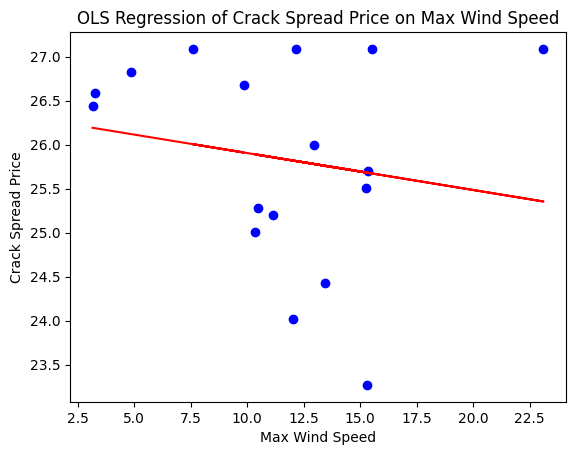

In [42]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Extracting the aligned wind speed data
aligned_max_harr = wind_speed_data['max_harr'].values

# Reshape data for sklearn
X = aligned_max_harr.reshape(-1, 1)
y = wind_speed_data['aligned_crack_spread']

# Adding a constant to the model for the intercept
X_with_constant = sm.add_constant(X)

# Building the OLS model
ols_model = sm.OLS(y, X_with_constant)

# Fitting the OLS model
ols_results = ols_model.fit()

# Printing the summary statistics
print("OLS Regression Results:")
print(ols_results.summary())

# Plotting the results
plt.scatter(X, y, color='blue')
plt.plot(X, ols_results.predict(X_with_constant), color='red')
plt.xlabel('Max Wind Speed')
plt.ylabel('Crack Spread Price')
plt.title('OLS Regression of Crack Spread Price on Max Wind Speed')
plt.show()



Results for different lags:
Lag: 0 minutes, R²: 0.03186841774911797, Coefficient: -0.04195122401390168, P-value: 0.49301593699791
Lag: 30 minutes, R²: 0.02224743443106947, Coefficient: -0.03520800319265876, P-value: 0.5677600641246274
Lag: 60 minutes, R²: 0.019905466088874446, Coefficient: -0.032978559022758806, P-value: 0.5891138498788533
Lag: 90 minutes, R²: 0.015175052923211307, Coefficient: -0.02850552839990448, P-value: 0.637621712555897
Lag: 120 minutes, R²: 0.013358376391313986, Coefficient: -0.027183650411242297, P-value: 0.6586849377255191
Lag: 150 minutes, R²: 0.061206797305061844, Coefficient: -0.06480269716441964, P-value: 0.3937955691679108
Lag: 180 minutes, R²: 0.07367004416921663, Coefficient: -0.07239663931601166, P-value: 0.34789881649119225
Lag: 210 minutes, R²: 0.14119810806228072, Coefficient: -0.10402005744018572, P-value: 0.13717040757440854
Lag: 240 minutes, R²: 0.17538602208255638, Coefficient: -0.11249326549334025, P-value: 0.09430068964015452
Lag: 270 minutes,

/var/folders/56/glwsl01j2jv_87_l49k_p9tw0000gn/T/ipykernel_10026/3754062503.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Coefficient': ols_results.params[1],
/var/folders/56/glwsl01j2jv_87_l49k_p9tw0000gn/T/ipykernel_10026/3754062503.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'P_value': ols_results.pvalues[1]
/var/folders/56/glwsl01j2jv_87_l49k_p9tw0000gn/T/ipykernel_10026/3754062503.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position,

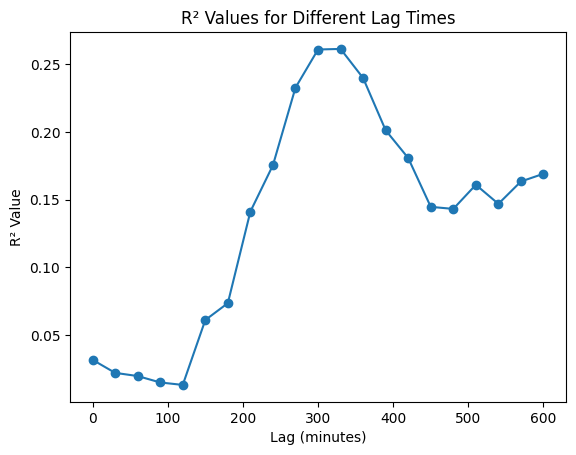

In [45]:
import pandas as pd
from scipy.spatial import KDTree
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Your initial data: max_harr and t_release
# max_harr = [...]
# t_release = [...]

# Define the range of lags to test
lag_range = range(0, 601, 30)  # From 30 to 300 minutes, in steps of 30 minutes

# Dictionary to store results for each lag
results = {}

# Loop over the specified range of lags
for lag_minutes in lag_range:
    # Steps 1 to 5 from your code with adjusted lag
    wind_speed_data = pd.DataFrame({
        'datetime': pd.Series(t_release),
        'max_harr': max_harr
    }).query('max_harr >= 0')

    wind_speed_data['datetime_lagged'] = wind_speed_data['datetime'] + pd.to_timedelta(lag_minutes, unit='min')
    wind_speed_seconds = wind_speed_data['datetime_lagged'].apply(lambda x: x.timestamp()).values

    pivoted_data_seconds = pivoted_data.index.map(lambda x: x.timestamp())
    tree = KDTree(pivoted_data_seconds.values.reshape(-1, 1))
    _, indices = tree.query(wind_speed_seconds.reshape(-1, 1))

    aligned_crack_spreads = pivoted_data['crack_spread_X0'].iloc[indices].values
    wind_speed_data['aligned_crack_spread'] = aligned_crack_spreads
    wind_speed_data = wind_speed_data.dropna()

    # Regression Analysis for each lag
    X = wind_speed_data['max_harr'].values.reshape(-1, 1)
    y = wind_speed_data['aligned_crack_spread']

    X_with_constant = sm.add_constant(X)
    ols_model = sm.OLS(y, X_with_constant)
    ols_results = ols_model.fit()

    # Record results
    results[lag_minutes] = {
        'R_squared': ols_results.rsquared,
        'Coefficient': ols_results.params[1],
        'P_value': ols_results.pvalues[1]
    }

# Print the results for each lag
print("Results for different lags:")
for lag, result in results.items():
    print(f"Lag: {lag} minutes, R²: {result['R_squared']}, Coefficient: {result['Coefficient']}, P-value: {result['P_value']}")

# Optionally, plot the R² values
plt.figure()
plt.plot([lag for lag in results], [result['R_squared'] for result in results.values()], marker='o')
plt.xlabel('Lag (minutes)')
plt.ylabel('R² Value')
plt.title('R² Values for Different Lag Times')
plt.show()


In [5]:
import statsmodels.api as sm

# Adding a constant to the model for the intercept
X_with_constant = sm.add_constant(X)

# Building the model
model = sm.OLS(y, X_with_constant)

# Fitting the model
results = model.fit()

# Printing the summary statistics
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     9.050
Date:                Fri, 01 Mar 2024   Prob (F-statistic):            0.00447
Time:                        03:11:34   Log-Likelihood:                -137.67
No. Observations:                  43   AIC:                             279.3
Df Residuals:                      41   BIC:                             282.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         54.2165      1.558     34.791      0.0

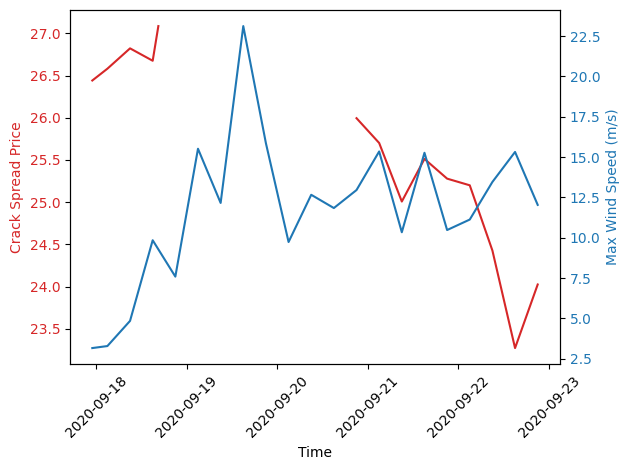

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming t_release and pivoted_data.index are already aligned as per your previous instructions
# and 'aligned_crack_spread' contains the corresponding crack spread values

# Plotting
fig, ax1 = plt.subplots()

# Setting up the first axis for crack spread prices
color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Crack Spread Price', color=color)
ax1.plot(pivoted_data.index[indices], aligned_crack_spread, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Setting up the x-axis for dates
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

# Setting up the second axis for max wind speed
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Max Wind Speed (m/s)', color=color)
ax2.plot(t_release_series, max_harr, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Show plot
fig.tight_layout()
plt.show()


In [7]:
import pandas as pd
import numpy as np
import scipy.stats

# Assuming max_harr and aligned_crack_spread are your data series

# Pearson Correlation
pearson_corr, _ = scipy.stats.pearsonr(max_harr, aligned_crack_spread)
print(f'Pearson Correlation Coefficient: {pearson_corr}')

# Spearman's Rank Correlation
spearman_corr, _ = scipy.stats.spearmanr(max_harr, aligned_crack_spread)
print(f'Spearman Rank Correlation Coefficient: {spearman_corr}')

# Kendall's Tau
kendall_tau, _ = scipy.stats.kendalltau(max_harr, aligned_crack_spread)
print(f'Kendall Tau Coefficient: {kendall_tau}')


Pearson Correlation Coefficient: 0.42523783770209195
Spearman Rank Correlation Coefficient: 0.5813490819737964
Kendall Tau Coefficient: 0.38678685654787964


Time lag

In [9]:
import pandas as pd
import statsmodels.api as sm

# Create DataFrame for wind speed data
wind_speed_data = pd.DataFrame({
    't_release': t_release,
    'max_harr': max_harr
})
wind_speed_data.set_index('t_release', inplace=True)

# Align wind speed data with crack spread data
aligned_data = pivoted_data['crack_spread_V7'].to_frame().join(wind_speed_data, how='inner')

# Generate lagged wind speed data
for lag in range(1, 4):
    aligned_data[f'max_harr_lag_{lag}'] = aligned_data['max_harr'].shift(lag)

# Drop rows with NaN values (due to lagging)
aligned_data.dropna(inplace=True)

# Separate dependent and independent variables
X = aligned_data[['max_harr', 'max_harr_lag_1', 'max_harr_lag_2', 'max_harr_lag_3']]
y = aligned_data['crack_spread_V7']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Create a model and fit it
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:        crack_spread_V7   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     1.503
Date:                Fri, 01 Mar 2024   Prob (F-statistic):              0.239
Time:                        03:12:43   Log-Likelihood:                -79.996
No. Observations:                  25   AIC:                             170.0
Df Residuals:                      20   BIC:                             176.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             56.0673      3.095     18.

Using only t-1

In [11]:
import pandas as pd
import statsmodels.api as sm

# Assuming t_release, max_harr, and pivoted_data are already defined in your environment

# Create DataFrame for wind speed data
wind_speed_data = pd.DataFrame({
    't_release': t_release,
    'max_harr': max_harr
})
wind_speed_data.set_index('t_release', inplace=True)

# Align wind speed data with crack spread data
aligned_data = pivoted_data['crack_spread_V7'].to_frame().join(wind_speed_data, how='inner')

# Generate lagged wind speed data for t-1
aligned_data['max_harr_lag_1'] = aligned_data['max_harr'].shift(1)

# Drop rows with NaN values (due to lagging)
aligned_data.dropna(inplace=True)

# Separate dependent and independent variables
X = aligned_data[['max_harr_lag_1']]  # Only the t-1 lagged variable
y = aligned_data['crack_spread_V7']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Create a model and fit it
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:        crack_spread_V7   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     3.273
Date:                Fri, 01 Mar 2024   Prob (F-statistic):             0.0825
Time:                        03:17:23   Log-Likelihood:                -89.108
No. Observations:                  27   AIC:                             182.2
Df Residuals:                      25   BIC:                             184.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             56.2655      2.414     23.

USING the 1:1 Crack Spread

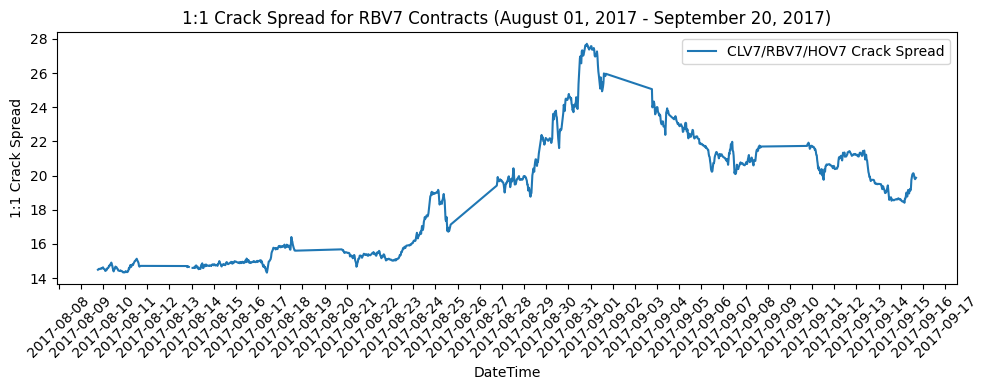

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Load data
file_path = 'bins17.csv'
data = pd.read_csv(file_path)

# Convert date and time to a datetime format
data['datetime'] = pd.to_datetime(data['date']) + pd.to_timedelta(data['time'], unit='min')

# Convert HO and RB prices to per barrel
data.loc[data['sym'].str.contains('HO') | data['sym'].str.contains('RB'), ['bid', 'ask', 'prc']] *= 42

# Filter data for the desired date range and specific contracts
start_date = datetime(2017, 8, 1)
end_date = datetime(2017, 9, 20)
filtered_data = data[(data['datetime'] >= start_date) & (data['datetime'] <= end_date)]
filtered_data = filtered_data[filtered_data['sym'].isin([ 'CLV7', 'RBV7', 'HOV7'])]


# Pivot the data for easier calculation
pivoted_data = filtered_data.pivot_table(index='datetime', columns='sym', values='prc')

# Calculate the 1:1 crack spread for gasoline
pivoted_data['basic_crack_spread_V7'] = -1* (pivoted_data['CLV7'] - pivoted_data['RBV7'])

# Plotting
plt.figure(figsize=(10, 4))
# plt.plot(pivoted_data.index, pivoted_data['crack_spread_U7'], label='CLU7/RBU7/HOU7 Crack Spread')
plt.plot(pivoted_data.index, pivoted_data['basic_crack_spread_V7'], label='CLV7/RBV7/HOV7 Crack Spread')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.xticks(rotation=45)
plt.xlabel('DateTime')
plt.ylabel('1:1 Crack Spread')
plt.title(f'1:1 Crack Spread for RBV7 Contracts ({start_date.strftime("%B %d, %Y")} - {end_date.strftime("%B %d, %Y")})')
plt.legend()
plt.tight_layout()
plt.show()


In [24]:
import pandas as pd
from scipy.spatial import KDTree

# Convert t_release to a pandas Series for easier handling
t_release_series = pd.Series(t_release)

# Convert t_release and pivoted_data.index to the same format (e.g., total seconds)
# for KDTree processing
time_format = lambda x: (x - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
t_release_seconds = t_release_series.apply(time_format)
pivoted_data_seconds = pivoted_data.index.map(time_format)

# Build a KDTree for efficient nearest neighbor search
tree = KDTree(pivoted_data_seconds.values.reshape(-1, 1))

# Find the nearest neighbor for each time in t_release
_, indices = tree.query(t_release_seconds.values.reshape(-1, 1))

# Extract the corresponding crack spread values
aligned_crack_spread = pivoted_data['basic_crack_spread_V7'].iloc[indices]


Slope: 0.16867079645207855
Intercept: 16.964196312726912


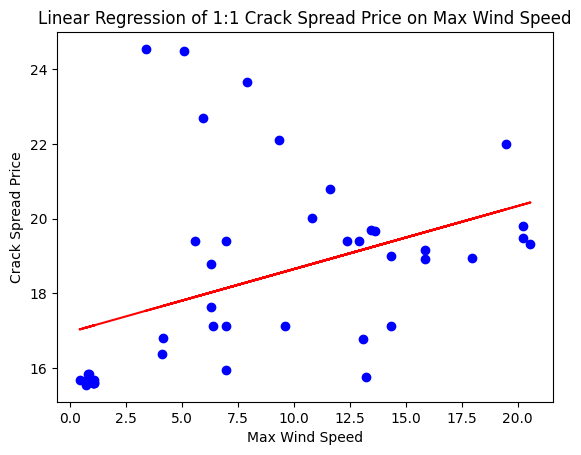

In [25]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Ensure that max_harr is a numpy array
max_harr_array = np.array(max_harr)

# Reshape data for sklearn
X = max_harr_array.reshape(-1, 1)
y = aligned_crack_spread.values

# Perform linear regression
model = LinearRegression()
model.fit(X, y)

# Coefficients
print("Slope:", model.coef_[0])
print("Intercept:", model.intercept_)

# Plotting the results
plt.scatter(X, y, color='blue')
plt.plot(X, model.predict(X), color='red')
plt.xlabel('Max Wind Speed')
plt.ylabel('Crack Spread Price')
plt.title('Linear Regression of 1:1 Crack Spread Price on Max Wind Speed')
plt.show()


In [26]:
import statsmodels.api as sm

# Adding a constant to the model for the intercept
X_with_constant = sm.add_constant(X)

# Building the model
model = sm.OLS(y, X_with_constant)

# Fitting the model
results = model.fit()

# Printing the summary statistics
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     8.580
Date:                Thu, 29 Feb 2024   Prob (F-statistic):            0.00553
Time:                        17:56:26   Log-Likelihood:                -97.223
No. Observations:                  43   AIC:                             198.4
Df Residuals:                      41   BIC:                             202.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.9642      0.608     27.889      0.0

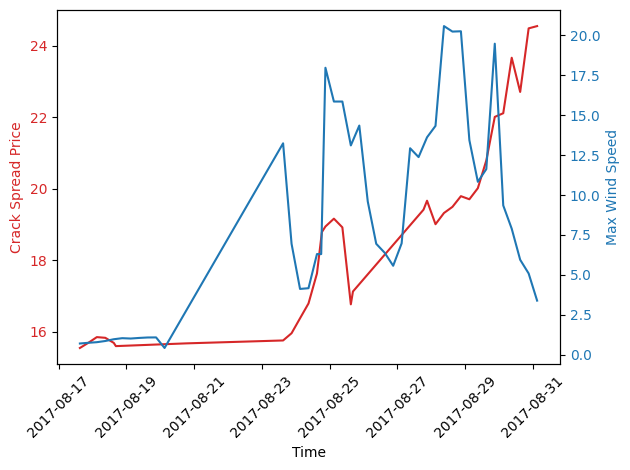

In [27]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming t_release and pivoted_data.index are already aligned as per your previous instructions
# and 'aligned_crack_spread' contains the corresponding crack spread values

# Plotting
fig, ax1 = plt.subplots()

# Setting up the first axis for crack spread prices
color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Crack Spread Price', color=color)
ax1.plot(pivoted_data.index[indices], aligned_crack_spread, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Setting up the x-axis for dates
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

# Setting up the second axis for max wind speed
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Max Wind Speed', color=color)
ax2.plot(t_release_series, max_harr, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Show plot
fig.tight_layout()
plt.show()


In [33]:
import pandas as pd
import numpy as np
import scipy.stats

# Assuming max_harr and aligned_crack_spread are your data series

# Pearson Correlation
pearson_corr, _ = scipy.stats.pearsonr(max_harr, aligned_crack_spread)
print(f'Pearson Correlation Coefficient: {pearson_corr}')

# Spearman's Rank Correlation
spearman_corr, _ = scipy.stats.spearmanr(max_harr, aligned_crack_spread)
print(f'Spearman Rank Correlation Coefficient: {spearman_corr}')

# Kendall's Tau
kendall_tau, _ = scipy.stats.kendalltau(max_harr, aligned_crack_spread)
print(f'Kendall Tau Coefficient: {kendall_tau}')


Pearson Correlation Coefficient: 0.4159894716255769
Spearman Rank Correlation Coefficient: 0.5723523278604106
Kendall Tau Coefficient: 0.38006012860791655
